In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

from tabulate import tabulate

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Questão 1

A variável resposta é a coluna 'Class', com valor 1 caso seja fraude e valor 0 caso não seja.

In [8]:
df_train = pd.read_csv('train.csv', sep=',', decimal='.')
df_test = pd.read_csv('test.csv', sep=',', decimal='.')

<Axes: xlabel='Class', ylabel='Count'>

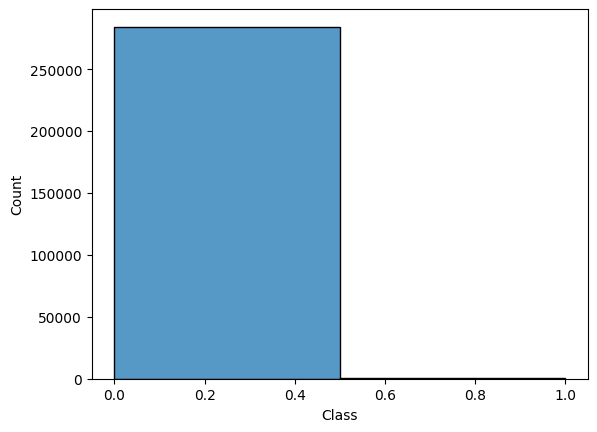

In [9]:
df = pd.concat([df_test, df_train])
sns.histplot(data=df, x='Class', bins=2)

In [10]:
frauds = (df['Class'].values == 1).sum()
frauds = 100 * frauds / df.shape[0]
print(f"Porcentage of frauds: {round(frauds, 2)}%")
print(f"Porcentage of non frauds: {100 - round(frauds, 2)}%")

Porcentage of frauds: 0.17%
Porcentage of non frauds: 99.83%


A coluna 'Time' indica o momento em que a transação foi realizada, ou seja, é um metadado que indica o tempo de criação dos dados a que se refere, portando não deve ser usada como input do modelo nem como o output desejado.

# Questão 2

In [11]:
y = df_test['Class'].to_numpy()

In [12]:
random_model = np.random.binomial(size=y.shape[0], p=0.5, n=1)
fraud_model = np.ones(y.shape[0])
not_fraud_model = np.zeros(y.shape[0])

In [13]:
acc_random = accuracy_score(y, random_model)
acc_fraud = accuracy_score(y, fraud_model)
acc_not_fraud = accuracy_score(y, not_fraud_model)

In [14]:
auc_random = roc_auc_score(y, random_model)
auc_fraud = roc_auc_score(y, fraud_model)
auc_not_fraud = roc_auc_score(y, not_fraud_model)

In [15]:
table = [['',        'Random',    'Always fraud',   'Never fraud'], 
         ['Accuracy', acc_random, acc_fraud,        acc_not_fraud], 
         ['AUC',      auc_random, auc_fraud,        auc_not_fraud]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign="center"))

╒══════════╤══════════╤════════════════╤═══════════════╕
│          │  Random  │  Always fraud  │  Never fraud  │
╞══════════╪══════════╪════════════════╪═══════════════╡
│ Accuracy │ 0.499343 │   0.00156598   │   0.998434    │
├──────────┼──────────┼────────────────┼───────────────┤
│ AUC      │  0.5187  │      0.5       │      0.5      │
╘══════════╧══════════╧════════════════╧═══════════════╛


Visto que os três modelos não consideram nenhum input, são todos ruins, logo as métricas deveriam refletir isso. A acurácia, então, não é uma métrica apropriada, tendo em vista seu resultado próximo a 1 para o modelo que sempre classifica as transações como não fraudulentas. Isso se deve à má adaptação da acurácia para bases de dados não balanceadas, como é o caso, já que a grande maioria das transações são não fraudulentas. Portanto, a melhor métrica para ser utilizada aqui é a AUC.

# Questão 3

In [16]:
X = df_train.drop(['Class'], axis=1)
X = X.drop(['Time'], axis=1)
y = df_train['Class']

In [17]:
parameters = {'n_estimators':[10, 50, 100, 200], 'max_depth':[2, 3, 4, 5]}

In [18]:
rfc_a = RandomForestClassifier(random_state = 42) 
grid_a = GridSearchCV(estimator = rfc_a,          
                    param_grid = parameters,  
                    scoring = 'roc_auc',           
                    cv = 3) 

In [19]:
grid_a.fit(X, y)
pd.DataFrame(grid_a.cv_results_)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
0,"{'max_depth': 2, 'n_estimators': 10}",16,0.917621
1,"{'max_depth': 2, 'n_estimators': 50}",14,0.932838
2,"{'max_depth': 2, 'n_estimators': 100}",15,0.932678
3,"{'max_depth': 2, 'n_estimators': 200}",11,0.943110
4,"{'max_depth': 3, 'n_estimators': 10}",13,0.941626
5,"{'max_depth': 3, 'n_estimators': 50}",12,0.942590
6,"{'max_depth': 3, 'n_estimators': 100}",8,0.950664
7,"{'max_depth': 3, 'n_estimators': 200}",7,0.954357
8,"{'max_depth': 4, 'n_estimators': 10}",10,0.944402
9,"{'max_depth': 4, 'n_estimators': 50}",4,0.961995


Portanto, a melhor combinação de parâmetros é max_depth = 5 e n_estimators = 100.

Com o hiperparâmetro 'class_weight' sendo 'balanced', as linhas de dados terão peso na avaliação inversamente proporcional à frequência da sua classe na base de dados, ou seja, os casos de fraude terão maior peso do que anteriormente, em que o hiperparâmetro padrão era utilizado.

In [20]:
rfc_b = RandomForestClassifier(random_state = 42, class_weight='balanced') 
grid_b = GridSearchCV(estimator = rfc_b,          
                    param_grid = parameters,  
                    scoring = 'roc_auc',           
                    cv = 3) 

In [21]:
grid_b.fit(X, y)
pd.DataFrame(grid_b.cv_results_)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
0,"{'max_depth': 2, 'n_estimators': 10}",16,0.958461
1,"{'max_depth': 2, 'n_estimators': 50}",13,0.968971
2,"{'max_depth': 2, 'n_estimators': 100}",14,0.966224
3,"{'max_depth': 2, 'n_estimators': 200}",11,0.970468
4,"{'max_depth': 3, 'n_estimators': 10}",15,0.959800
5,"{'max_depth': 3, 'n_estimators': 50}",12,0.970257
6,"{'max_depth': 3, 'n_estimators': 100}",9,0.971872
7,"{'max_depth': 3, 'n_estimators': 200}",8,0.972556
8,"{'max_depth': 4, 'n_estimators': 10}",10,0.971551
9,"{'max_depth': 4, 'n_estimators': 50}",3,0.978525


Portanto a melhor combinação de parâmetros encontrada, ajustando os pesos para compensar o desbalanceamento da base de dados, é max_depth = 5 e n_estimators = 50.

# Questão 4

In [22]:
X_test = df_test.drop(['Class'], axis=1)
X_test = X_test.drop(['Time'], axis=1)
y_test = df_test['Class'].to_numpy()

In [23]:
probabilities = grid_b.predict_proba(X_test)

In [24]:
# concatenate probabilities with actual result
compare = np.insert(probabilities, 0, y_test, axis=1)
# sort by probability of being a fraud
compare = compare[compare[:, 2].argsort()[::-1]]
# take the top 1%
compare = compare[0:compare.shape[0]//100]

lucro = 0
for line in compare:
  if line[0] == 1: 
    lucro += 100
  else:
    lucro -= 2

In [25]:
print(f"O lucro obtido seria R$ {lucro}")

O lucro obtido seria R$ 16532
